# The Baseball Futures Market

### Introduction

   As the Supreme Court nears its decision on the latest sports gambling case, the nation may be looking at new and robust market. Gambling in the United States may soon shed its notorious ambiguity, opening the door for newly-legitimized work in data science. Daily fantasy, which users pay money to participate in a predictions and win money for correct picks (gambling in any reasonable interpretation of the word), is constantly advertised and in fact promoted by the major sports leagues through lucrative sponsorship deals, sending a majority of payouts to the top five percent of players.
   
   Getting gambling away from the draconian tactics of Las Vegas casinos will only open the market to fairer play and lower the barrier to (legal) entry into the industry. Black market gambling is a multi-billion-dollar space, filled with die-hard and delusional fans without the ability to use data science as an informative tool in their investments. And unlike legitimate futures markets that trade commodities and financial products, teams will actually be punished for fixing games.

### Who Might Care

The average fan knows nearly nothing about predicting game outcomes. The problems associated with a twenty-four hour news cycle are not lost on sports--talk radio personalities drive a narrative and television hosts have a panel of nonsense every night. Sports, in other words, has the same potential for misinformation and therefore the same potential for exploiting inefficiencies.

Much like financial markets, sporting event outcomes are priced for their likelihood. If your team can’t win, maybe you can pick players and teams that will perform. So, this project is for the disgruntled fan, sick of waiting around for Midas to grace their team with a touch of gold, who instead wants to become a part of the entertainment, forgetting what they cannot control and instead focusing on what they can. There are already some great sites that provide apps and newsletters for the amateur gambler. It's a growing space that reaches out directly to the consumer and has an unknown (untested) ceiling.

This project's ambitious aim is to illuminate what can accurately predict the winner of a game, hopefully, parsing out the signal from the noise.

### Data Wrangling

A lot of what holds sports analytics back is inaccessible data. It’s difficult to get your hands on and it’s prohibitively expensive to the average fan, but fundamental to how sports organizations view their business. Stattleship API gives community access to Sports Radar data for a small donation every month. This eliminates a huge barrier that casuals face in analyzing sports data. They host a wealth of data on team performance and individual stats available in almost infinite combinations. So for most sports, this a great way to go.

However, any baseball analysis leads back to one main source: Retrosheet. It's a comprehensive community efforts spearheaded and supported by baseball statisticians inspired by the Moneyball revolution started by Bill James's sabermetrics approach. Bill James remains the Hadley Wickham of baseball data, the Guido von Rossum of understanding the sport: perpetually present and forward-looking, inescapable, King James the All-Seeing.

I was able to obtain historical odds for baseball games going back to 2009, so this analysis will focus on the last nine years of regular season baseball. After connecting the two data sources, I'll have summarized information leading up to the game, the game results, and the cost to wager on an outcome.

Retrosheet event files are in a unique format, but luckily there are a lot of resources that explain how to gather and process the data into CSV files. After some frustrating hours, I was able to compile data going back to 2009, though the same level of information is available going back to the 1950's.

I separated out performance into three areas--starting pitching, bullpen pitching, and batting--for the home and away teams. I recreated some popular and predictive sabermetric statistics and some general summaries, rolled up in season averages and averages for the last five and ten games respectively. In this way, I'll be able to see career data for pitchers and seasonal data for the bullpen and offense and do a comparison to see over-and-under performance relative to their average performace. Do each of these units regress towards the mean? Or do they trend in some direction?

Each game has calculations comparing the average of the starting pitchers and bullpen of one team with the offense of the other. The most promising as I see it: Pythagorean Win Expectation; flyball-to-home run ratio; line drive rate; Batting Average on Balls in Play (BABIP); strikeout-to-walk ratio; Weighted on Base Average (wOBA).

The odds data has the starting and ending prices for an outcome including a win and over/under a given number of runs (usually six or seven). In addition to the price, it includes the outcome for bet, giving me a series of categories to perform a logistic regression on.

The interesting dynamic offered in this exercise is the ability to change the amount wagered based on a confidence level. Given my performance columns, how confident am I that the Astros will beat the Dodgers? That confidence level--calculated through a linear regression--can inform my bet amount and inject some excitement in how I play the market.

If I wanted to take this a step further, I could wrangle some Pitch F/X data, which tracks each pitch, its location, type, the result of the at bat, and a hit location if applicable. From this, I could find out if a batting lineup struggles with sliders and predict how they would perform against a starting pitcher that dominates with one. For now, however, I'll stick to Retrosheet and search for indicators in more general summaries.

In [47]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

#### Final Dataset
The following is the final data set in preparation for the Machine Learning portion of the project. It was compiled using the notebook entitled: Game & Odds Compilation.

In [48]:
bball = pd.read_csv(r'C:\\Users\\mendo\\Desktop\\final_game_info.csv', sep=',',low_memory=False,  header=0, index_col=0)
bball = bball[bball['month'] != 'Apr'][bball['month'] != 'Mar']
bball.head(10)

C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,game_id,odds_matchup,date,weekday,season,month,start_time,duration,total_innings,day_night,game_site,attendance,home_final,vis_final,dh_used,home_team,visiting_team_x,home_plate_ump,base1_ump,base2_ump,base3_ump,temperature,wind_dir,wind_speed,field_cond,precipitation,sky,home_starting_pitcher,vis_starting_pitcher,winning_pitcher,losing_pitcher,save,home_hits,vis_hits,home_errors,vis_errors,home_lob,vis_lob,winner,home_minus_1,home_plus_1,away_minus_1,away_plus_1,ou_6,ou_7,ou_8,ou_9,p_ml_home_start,p_ml_away_start,p_ml_home_final,p_ml_away_final,p_over_6-5_final,p_under_6-5_final,p_over_7-5_final,p_under_7-5_final,p_over_8-5_final,p_under_8-5_final,wager,winning_team,losing_team,winning_runs,losing_runs,ml_h_win,ml_a_win,h_ml_result,v_ml_result,home_team_x,visiting_team_y,home_win_c,home_loss_c,vis_win_c,vis_loss_c,home_p_win_percentage_x,vis_p_win_percentage_x,home_x_wins,vis_x_wins,home_x_win_diff,vis_x_win_diff,home_r_wins,home_r_losses,home_r_runs_scored,home_r_runs_allowed,home_games,home_games_played,home_win_percentage,home_p_win_percentage_y,home_expected_wins,home_expected_losses,home_win_difference,vis_r_wins,vis_r_losses,vis_r_runs_scored,vis_r_runs_allowed,vis_games,vis_games_played,vis_win_percentage,vis_p_win_percentage_y,vis_expected_wins,vis_expected_losses,vis_win_difference,home_s_pitcher,home_s_pitcher_hand,home_s_ab_5,home_s_ab_10,home_s_ldr_c,home_s_ldr_5,home_s_ldr_10,home_s_gbr_c,home_s_gbr_5,home_s_gbr_10,home_s_fbr_c,home_s_fbr_5,home_s_fbr_10,home_s_hr_fb_c,home_s_hrfb_5,home_s_hrfb_10,home_s_xFIP_c,home_s_xFIP_5,home_s_xFIP_10,home_s_wOBA_c,home_s_wOBA_5,home_s_wOBA_10,home_s_BABIP_c,home_s_BABIP_5,home_s_BABIP_10,home_s_kb_r_c,home_s_kb_r_5,home_s_kb_r_10,home_b_ab_5,home_b_ab_10,home_b_ldr_c,home_b_ldr_5,home_b_ldr_10,home_b_gbr_c,home_b_gbr_5,home_b_gbr_10,home_b_fbr_c,home_b_fbr_5,home_b_fbr_10,home_b_hr_fb_c,home_b_hrfb_5,home_b_hrfb_10,home_b_xFIP_c,home_b_xFIP_5,home_b_xFIP_10,home_b_wOBA_c,home_b_wOBA_5,home_b_wOBA_10,home_b_BABIP_c,home_b_BABIP_5,home_b_BABIP_10,home_b_kb_r_c,home_b_kb_r_5,home_b_kb_r_10,home_bat_ab_5,home_bat_ab_10,home_bat_ldr_c,home_bat_ldr_5,home_bat_ldr_10,home_bat_gbr_c,home_bat_gbr_5,home_bat_gbr_10,home_bat_fbr_c,home_bat_fbr_5,home_bat_fbr_10,home_bat_hr_fb_c,home_bat_hrfb_5,home_bat_hrfb_10,home_bat_xFIP_c,home_bat_xFIP_5,home_bat_xFIP_10,home_bat_wOBA_c,home_bat_wOBA_5,home_bat_wOBA_10,home_bat_BABIP_c,home_bat_BABIP_5,home_bat_BABIP_10,home_bat_kb_r_c,home_bat_kb_r_5,home_bat_kb_r_10,vis_s_pitcher,vis_s_pitcher_hand,vis_s_ab_5,vis_s_ab_10,vis_s_ldr_c,vis_s_ldr_5,vis_s_ldr_10,vis_s_gbr_c,vis_s_gbr_5,vis_s_gbr_10,vis_s_fbr_c,vis_s_fbr_5,vis_s_fbr_10,vis_s_hr_fb_c,vis_s_hrfb_5,vis_s_hrfb_10,vis_s_xFIP_c,vis_s_xFIP_5,vis_s_xFIP_10,vis_s_wOBA_c,vis_s_wOBA_5,vis_s_wOBA_10,vis_s_BABIP_c,vis_s_BABIP_5,vis_s_BABIP_10,vis_s_kb_r_c,vis_s_kb_r_5,vis_s_kb_r_10,vis_b_ab_5,vis_b_ab_10,vis_b_ldr_c,vis_b_ldr_5,vis_b_ldr_10,vis_b_gbr_c,vis_b_gbr_5,vis_b_gbr_10,vis_b_fbr_c,vis_b_fbr_5,vis_b_fbr_10,vis_b_hr_fb_c,vis_b_hrfb_5,vis_b_hrfb_10,vis_b_xFIP_c,vis_b_xFIP_5,vis_b_xFIP_10,vis_b_wOBA_c,vis_b_wOBA_5,vis_b_wOBA_10,vis_b_BABIP_c,vis_b_BABIP_5,vis_b_BABIP_10,vis_b_kb_r_c,vis_b_kb_r_5,vis_b_kb_r_10,vis_bat_ab_5,vis_bat_ab_10,vis_bat_ldr_c,vis_bat_ldr_5,vis_bat_ldr_10,vis_bat_gbr_c,vis_bat_gbr_5,vis_bat_gbr_10,vis_bat_fbr_c,vis_bat_fbr_5,vis_bat_fbr_10,vis_bat_hr_fb_c,vis_bat_hrfb_5,vis_bat_hrfb_10,vis_bat_xFIP_c,vis_bat_xFIP_5,vis_bat_xFIP_10,vis_bat_wOBA_c,vis_bat_wOBA_5,vis_bat_wOBA_10,vis_bat_BABIP_c,vis_bat_BABIP_5,vis_bat_BABIP_10,vis_bat_kb_r_c,vis_bat_kb_r_5,vis_bat_kb_r_10,m_ldr_def,m_ldr_off,m_gbr_def,m_gbr_off,m_hrfb_def,m_xFIP_def,m_xFIP_off,m_wOBA_def,m_wOBA_off,m_BABIP_def,m_BABIP_off,m_kbr_def,m_kbr_off,m_ldr_def_5,m_ldr_off_5,m_gbr_def_5,m_gbr_off_5,m_hrfb_def_5,m_xFIP_def_5,m_xFIP_off_5,m_wOBA_def_5,m_wOBA_off_5,m_BABIP_def_5,m_BABIP_off_5,m_kbr_def_5,m_kbr_off_5,m_ldr_def_10,m_ldr_off_10,m_gbr_def_10,m_gbr_off_10,m_hrfb_def_10,m_xFIP_def_10,m_xFIP_off_10,m_wOBA_def

Though this is the final data set for the Machine Learning portion of the project, the following graph was compiled outside of this notebook. It's useful to have game information in a single line, but for analyzing each team indivudally, the data needs to have two lines per game, one for each team. This next graph was created in the notebook entitled: 'Pythagorean Win-Loss.'

The Pythogorean Win Expectation (PWE) is a simple and powerful predictor for the number of wins a team should have given the runs they scored and runs they allowed. Below is a breakdown for eight years of data, separated by season and division, color-coded by team. The calculations reads as: a team has a 50% chance of having an actual record above or below the predicted value.

The graph below shows the changes in a team's win differencs compared to their PWE over the 162 games in a season. Some years and division keep a tight range, five games on either side, and some have a bit more of a spread. The logic behind this calculation is that a team that is consistently in close games cannot win all of them and is 'over-performing' relative to their run values. This illustrates how accurate PWE is over time. An interesting approach would be to analyze the difference between the PWE and the actual team record and, if a few variables can determine that difference, using that as a barometer to inform a game prediction.

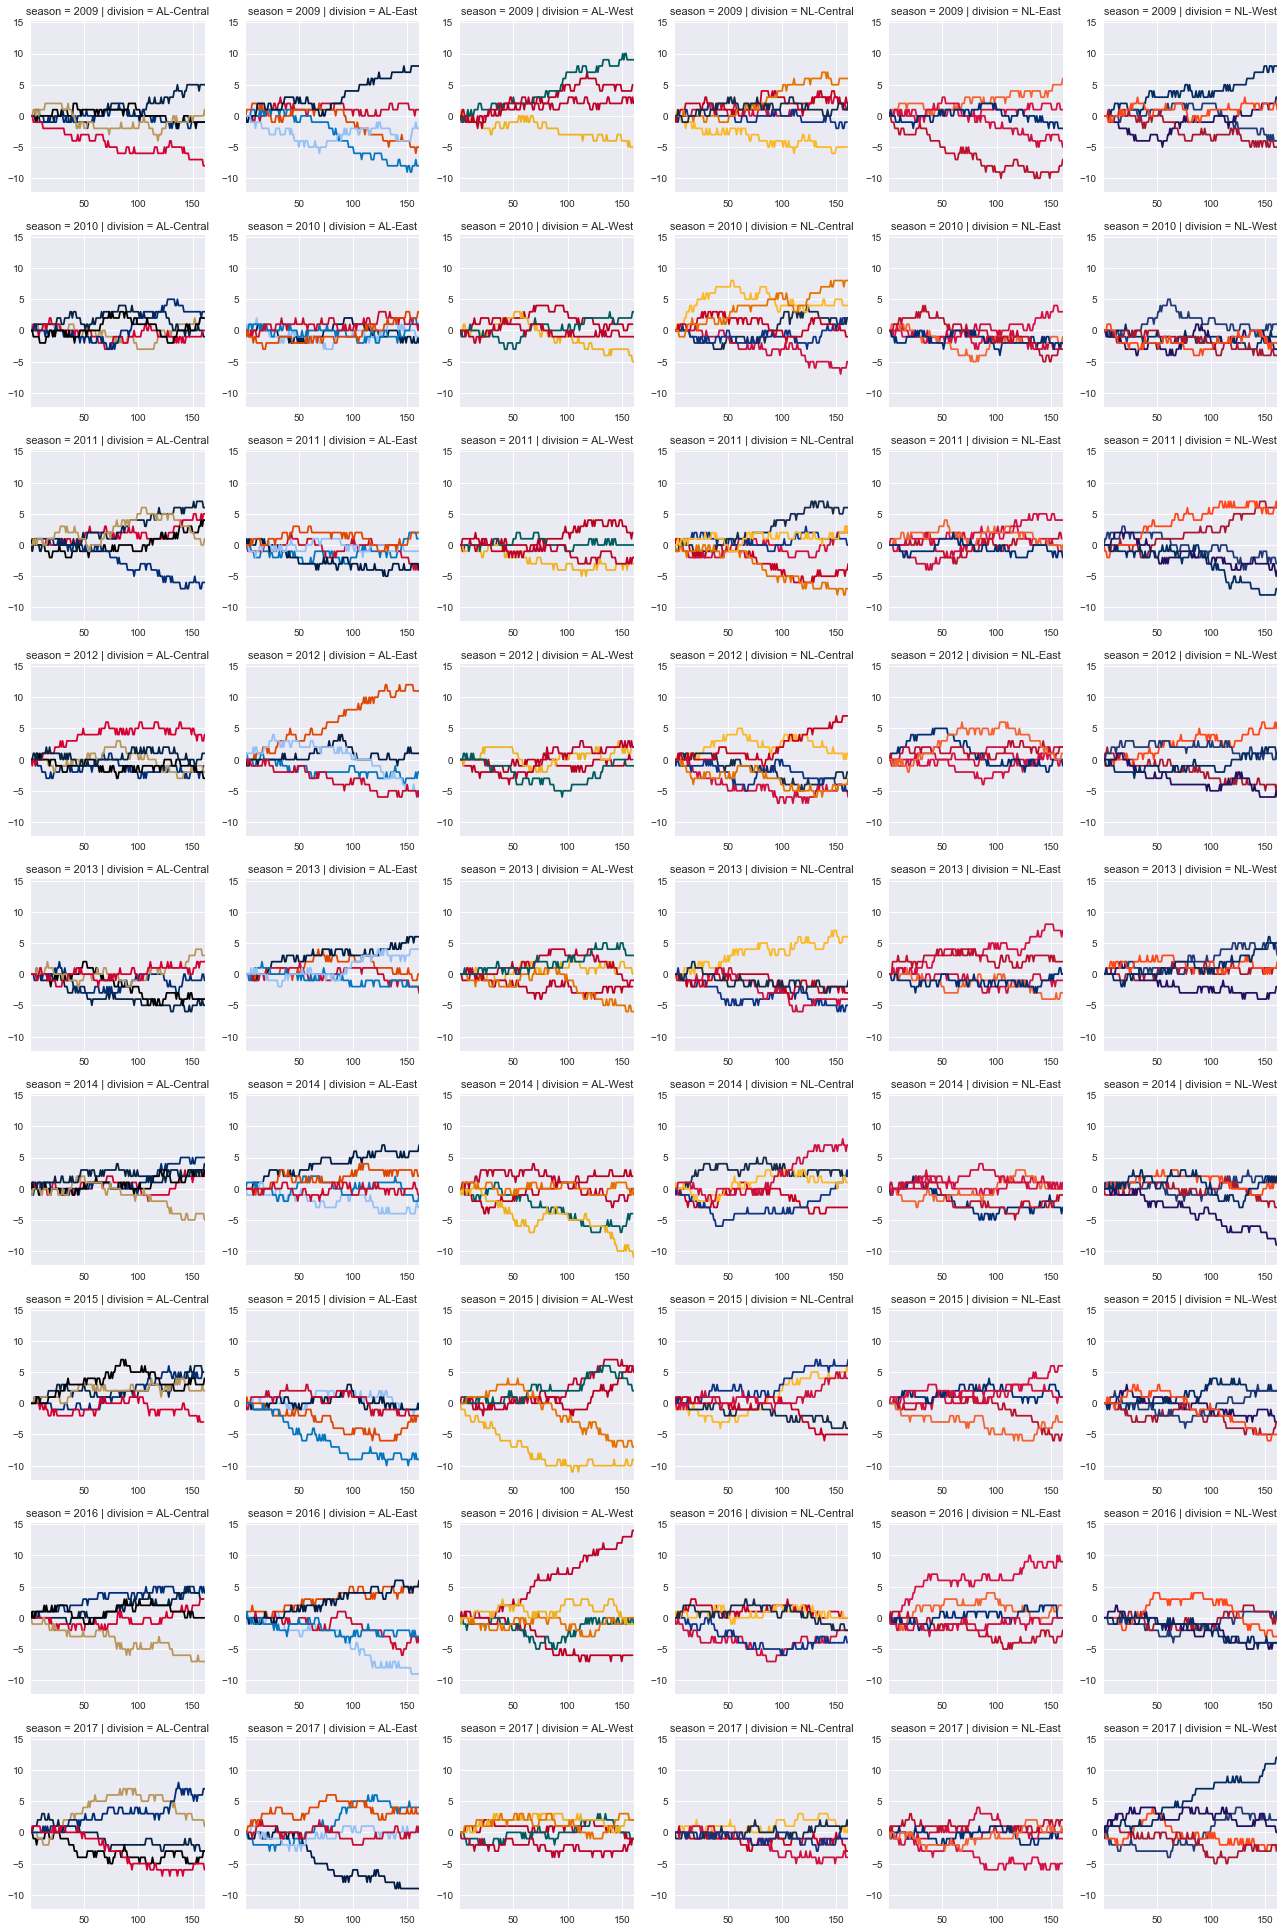

In [49]:
bball['comp_ldr'] = bball['m_ldr_def'] + bball['m_ldr_off']
bball['comp_gbr'] = bball['m_gbr_def'] + bball['m_gbr_off']
bball['comp_FIP'] = bball['m_xFIP_def'] + bball['m_xFIP_off']
bball['comp_wOBA'] = bball['m_wOBA_def'] + bball['m_wOBA_off']
bball['comp_BABIP'] = bball['m_BABIP_def'] + bball['m_BABIP_off']
bball['comp_kbr'] = bball['m_kbr_def'] + bball['m_kbr_off']

bball['comp_ldr_5'] = bball['m_ldr_def_5'] + bball['m_ldr_off_5']
bball['comp_gbr_5'] = bball['m_gbr_def_5'] + bball['m_gbr_off_5']
bball['comp_FIP_5'] = bball['m_xFIP_def_5'] + bball['m_xFIP_off_5']
bball['comp_wOBA_5'] = bball['m_wOBA_def_5'] + bball['m_wOBA_off_5']
bball['comp_BABIP_5'] = bball['m_BABIP_def_5'] + bball['m_BABIP_off_5']
bball['comp_kbr_5'] = bball['m_kbr_def_5'] + bball['m_kbr_off_5']

bball['comp_ldr_10'] = bball['m_ldr_def_10'] + bball['m_ldr_off_10']
bball['comp_gbr_10'] = bball['m_gbr_def_10'] + bball['m_gbr_off_10']
bball['comp_FIP_10'] = bball['m_xFIP_def_10'] + bball['m_xFIP_off_10']
bball['comp_wOBA_10'] = bball['m_wOBA_def_10'] + bball['m_wOBA_off_10']
bball['comp_BABIP_10'] = bball['m_BABIP_def_10'] + bball['m_BABIP_off_10']
bball['comp_kbr_10'] = bball['m_kbr_def_10'] + bball['m_kbr_off_10']

C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mendo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

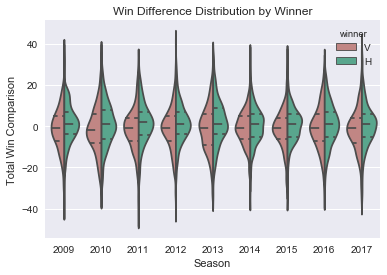

In [50]:
win_comp = bball[['season', 'home_team', 'home_win_c', 'home_r_wins', 'visiting_team_x', 'vis_win_c', 'vis_r_wins', 'winner']]
win_comp['home_win_at_home_perc'] = win_comp['home_win_c']/win_comp['home_r_wins']
win_comp['vis_win_away_perc'] = win_comp['vis_win_c']/win_comp['vis_r_wins']
win_comp['home_perc_diff'] = (win_comp['home_win_at_home_perc'] - win_comp['vis_win_away_perc']).round(3)
win_comp['win_diff'] =  win_comp['home_r_wins'] - win_comp['vis_r_wins']
win_comp['win_diff1'] = win_comp['home_win_c'] - win_comp['vis_win_c']

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.violinplot(x="season", y="win_diff", hue="winner", data=win_comp, split=True,
               inner="quart", palette={"H": "#4CB391", "V": "#cb7c7a"})
plt.title('Win Difference Distribution by Winner')
plt.ylabel('Total Win Comparison')
plt.xlabel('Season')
plt.show()

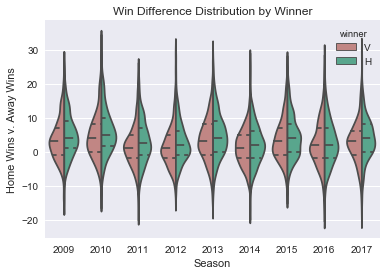

In [51]:
sns.violinplot(x="season", y="win_diff1", hue="winner", data=win_comp, split=True,
               inner="quart", palette={"H": "#4CB391", "V": "#cb7c7a"})
sns.despine(left=True)
plt.title('Win Difference Distribution by Winner')
plt.ylabel('Home Wins v. Away Wins')
plt.xlabel('Season')
plt.show()

The violin plots show win difference (compared to the home team) and the respective distributions of home and visitor victories. There isn't much variation from year to year. Immediately, we can see that an advantage in wins does not necessarily suggest a victory. 

The first plot shows overall win difference for each respective team's home and away victories. The second plot shows overall win difference comparing the home team's wins at home with the visiting team's wins on the road.

Now, let's observe how often the overs occur, how often the home team wins, how often the betting favorite wins and other anticipatory calculations.

In [52]:
bball['pyth_ratio_home'] = bball['home_p_win_percentage_x']/bball['vis_p_win_percentage_x']
bball['pyth_ratio_vis'] = bball['vis_p_win_percentage_x']/bball['home_p_win_percentage_x']
bball['pyth_diff'] = bball['home_p_win_percentage_x'] - bball['vis_p_win_percentage_x']
bball['total_win_ratio'] = bball['home_win_percentage']/bball['vis_win_percentage']
bball['final_score_diff'] = bball['home_final'] - bball['vis_final']

winner = []
for row in bball['winner']:
    if row=='H':
        winner.append(1)
    else:
        winner.append(0)
bball['home_win'] = winner

bball['total_runs'] = bball['home_final'] + bball['vis_final']

favorite = []
fav_team = []
for index, row in bball.iterrows():
    if row['p_ml_home_final'] < row['p_ml_away_final']:
        favorite.append(1)
        fav_team.append(row['home_team'])
    else:
        favorite.append(0)
        fav_team.append(row['visiting_team_x'])
bball['favorite'] = favorite
bball['fav_team'] = fav_team

In [53]:
fav_win = []        
for index, row in bball.iterrows():       
    if row['fav_team']==row['winning_team']:
        fav_win.append(1)
    else:
        fav_win.append(0)
bball['fav_win'] = fav_win

ou6 = []
ou7 = []
ou8 = []
for row in bball['total_runs']:
    if row > 8:
        ou6.append(1)
        ou7.append(1)
        ou8.append(1)
    elif row > 7:
        ou6.append(1)
        ou7.append(1)
        ou8.append(0)
    elif row > 6:
        ou6.append(1)
        ou7.append(0)
        ou8.append(0)
    else:
        ou6.append(0)
        ou7.append(0)
        ou8.append(0)
bball['ou6'] = ou6
bball['ou7'] = ou7
bball['ou8'] = ou8

In [54]:
nightgame = []
dh = []

for index, row in bball.iterrows():
    if row['day_night'] == 'N':
        nightgame.append(1)
    else:
        nightgame.append(0)
    if row['dh_used']=='T':
        dh.append(1)
    else:
        dh.append(0)
        
bball['nightgame'] = nightgame
bball['dh'] = dh

In [55]:
htw = (bball['home_win'].sum()/len(bball['home_win'])*100)
bf = bball['fav_win'].sum()/len(bball['fav_win'])*100
o6 = bball['ou6'].sum()/len(bball['ou6'])*100
o7 = bball['ou7'].sum()/len(bball['ou7'])*100
o8 = bball['ou8'].sum()/len(bball['ou8'])*100

print('Home Team Win:', htw, '%')
print('Betting Favorite Win :', bf, '%')

print('Over 6 :', o6, '%')
print('Over 7 :', o7, '%')
print('Over 8 :', o8, '%')

Home Team Win: 54.14987912973409 %
Betting Favorite Win : 57.72898200376041 %
Over 6 : 66.3644910018802 %
Over 7 : 55.06983615363954 %
Over 8 : 47.172978780553315 %


The correlation plot below begins to investigtate the connection between the winner (Home or Away), their win percentage, and the odds. No correlation is particularly strong; however, there are some interesting trends. 

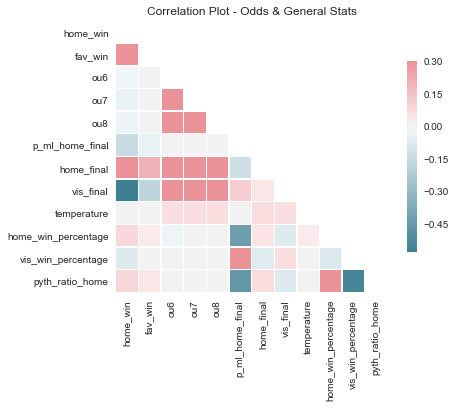

In [56]:
df1 = bball[['home_win', 'fav_win', 'ou6', 'ou7', 'ou8', 'p_ml_home_final', 'home_final', 
             'vis_final', 'temperature', 'home_win_percentage', 'vis_win_percentage',
             'pyth_ratio_home']]


corr1 = df1.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Plot - Odds & General Stats')
plt.show()

A higher temperature is associated with a higher run total for both teams--this supports the theory that the ball travels farther in hotter air, no surprise there.

There's a negative correlation between a visiting team's win percentage and the number of runs the home team scores and a positive correlation with their own number of runs. In short: better teams typically score more and allow fewer runs. This is in no way groundbreaking, but what is notable, though, is the relatively weak correlation between those variables. 

A better team often loses--teams with over 100 wins are exceptional, but even they lose close to forty percent of the time. What are the conditions that point to an upset? These are the games with more favorable odds and, not coincidentally, are harder to predict.

Now, we're going to dive in to the calculated features. 

All of the calculated stats compare the away team to the home team. 'ldr_def' compares the average of the home starting pitcher and bullpen to the visiting team's batting numbers. 'ldr_off' compares the home team's batting to the the mean of the visiting team's starting pitcher and bullpen. In this way, we can observe pitching versus hitting matchups. A negative def stat implies an advantage for the visiting team and vise versa.

LDR: linedrive rate

GBR: grounball rate

FIP: Fielding Independent Pitching

wOBA: Weighted On Base Average

BABIP: Batting Average on Balls in Play

KBR: strikeout to walk ratio

Each of these has a comparison for the cumulative average and comparisons for the last five and ten games respectively. If the better team doesn't always win, perhaps their recent performance can illuminate some of the reasons for those losses.

First, let's look at the cumulative measures and compare them to the winner, over/unders, and the home and visitor final scores.

A positive pyth ratio for the home team corresponds to a home win--if not nsightful, it's a good gut check. In that same vein, a better LDR rate is associated with a higher win percentage--they're making better contact with the ball.

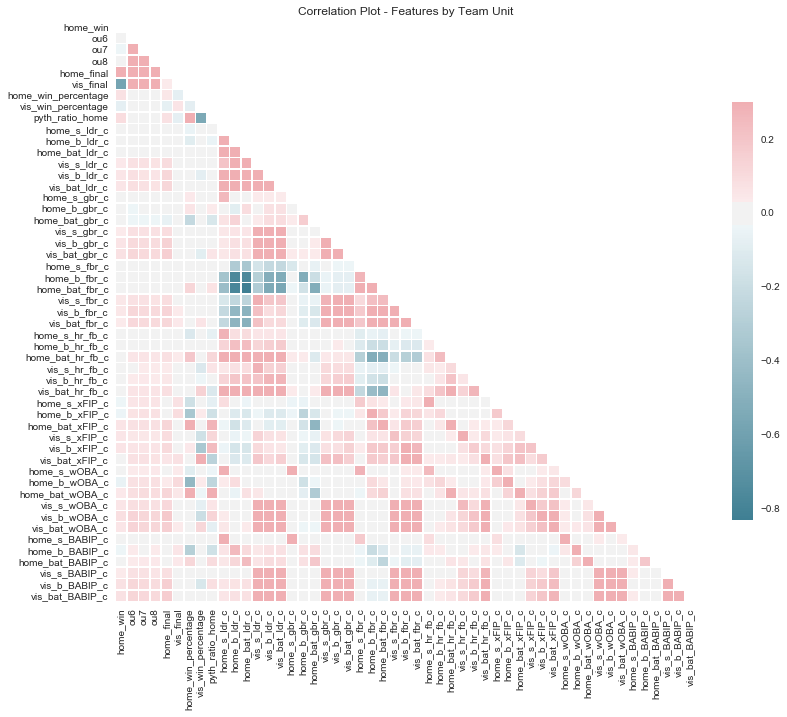

In [57]:
df = bball[['home_win', 'ou6', 'ou7', 'ou8', 'home_final', 'vis_final', 'home_win_percentage', 'vis_win_percentage', 'pyth_ratio_home',
            'home_s_ldr_c', 'home_b_ldr_c', 'home_bat_ldr_c', 'vis_s_ldr_c', 'vis_b_ldr_c', 'vis_bat_ldr_c',
           'home_s_gbr_c', 'home_b_gbr_c', 'home_bat_gbr_c', 'vis_s_gbr_c', 'vis_b_gbr_c', 'vis_bat_gbr_c',
           'home_s_fbr_c', 'home_b_fbr_c', 'home_bat_fbr_c', 'vis_s_fbr_c', 'vis_b_fbr_c', 'vis_bat_fbr_c',
           'home_s_hr_fb_c', 'home_b_hr_fb_c', 'home_bat_hr_fb_c', 'vis_s_hr_fb_c', 'vis_b_hr_fb_c', 'vis_bat_hr_fb_c',
           'home_s_xFIP_c', 'home_b_xFIP_c', 'home_bat_xFIP_c', 'vis_s_xFIP_c', 'vis_b_xFIP_c', 'vis_bat_xFIP_c',
           'home_s_wOBA_c', 'home_b_wOBA_c', 'home_bat_wOBA_c', 'vis_s_wOBA_c', 'vis_b_wOBA_c', 'vis_bat_wOBA_c',
           'home_s_BABIP_c', 'home_b_BABIP_c', 'home_bat_BABIP_c', 'vis_s_BABIP_c', 'vis_b_BABIP_c', 'vis_bat_BABIP_c']]

corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Plot - Features by Team Unit')
plt.show()

The graph above is a bit overwhelming, but I'm mainly focusing on the first six columns. What are the variables that correspond to a higher final score and home win?

There a good number of variables that have a positive correlation with the winner and final score. Rather than put in the graphs for the five and ten day rolling window, I'll just mention that the results were fairly similar, though FIP has a better correlation. It's encouraging to see some sort of relationship between the calculated fields and the outcomes considering it took forever and a day to get the two million rows wrangled.

The visitor score appears to have fewer correlated variables, though I'm expecting to see something significant with the comparison columns.

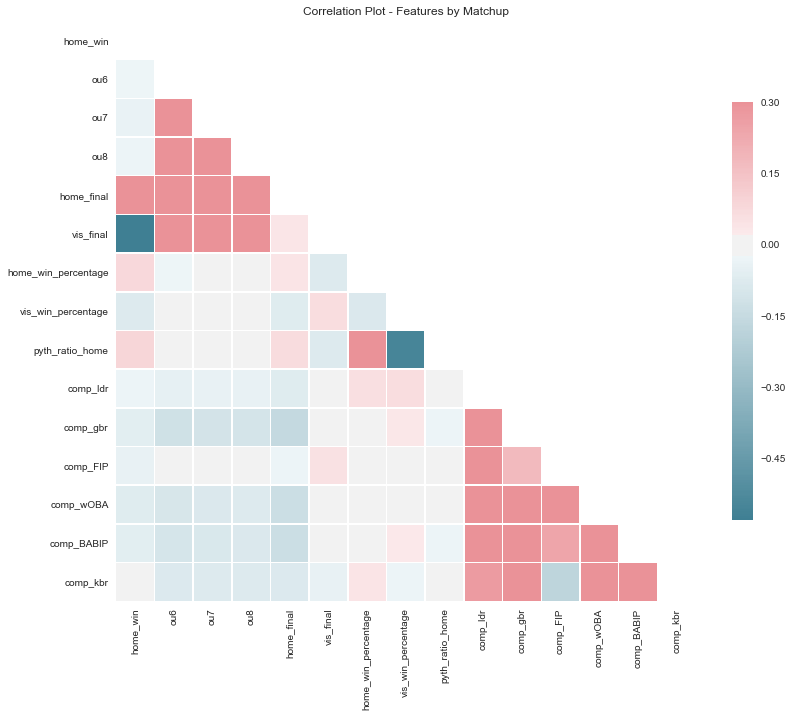

In [58]:
df = bball[['home_win', 'ou6', 'ou7', 'ou8', 'home_final', 'vis_final', 'home_win_percentage', 
            'vis_win_percentage', 'pyth_ratio_home','comp_ldr','comp_gbr', 'comp_FIP',
            'comp_wOBA', 'comp_BABIP', 'comp_kbr']]

corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style="white")
f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Plot - Features by Matchup')
plt.show()

Some of these results make intuitive sense--a higher strikeout/walk ratio (kbr) leads to fewer runs, a higher FIP comparison (the home team has an overall offensive disadvantage) leads to a higher vistor score. A higher groundball rate is associated with a lower score and home score. A better PWE is a great indicator of a home win.

But some are interestingly opposite of what I would expect: a more competitive batting history (better wOBA and BABIP) is associated with a lower home score and a better linedrive rate (a good barometer for batting contact) has a slightly negative correlation with the final home score.

The plot for the fiven and ten game streak looks very similar to the cumulative plot. Streaks must be important, but stat differences are pretty much average over ten games.

Let's look at some statistical analysis to see if there's a significant difference between these stats depending on which team eventually won the game. Because I'm comparing two different outcomes--with different means and standard deviations--I'll use ztest_ind() with usevar='unequal'. 

Null Hypotheses: there is no difference between the mean for variable-n for home victories and away victories.

In [59]:
h_win = bball[bball['winner']=='H'].fillna(0)
v_win = bball[bball['winner']=='V'].fillna(0)

import scipy.stats as stats
from statsmodels.stats.weightstats import CompareMeans


print()

test3 = CompareMeans.from_data(h_win['comp_ldr'], v_win['comp_ldr']).ztest_ind(usevar='unequal')
print('LDR Z-Test:', test3)

test4 = CompareMeans.from_data(h_win['comp_FIP'], v_win['comp_FIP']).ztest_ind(usevar='unequal')
print('FIP Z-Test:', test4)

test5 = CompareMeans.from_data(h_win['comp_BABIP'], v_win['comp_BABIP']).ztest_ind(usevar='unequal')
print('BABIP Z-Test:', test5)

test6 = CompareMeans.from_data(h_win['comp_wOBA'], v_win['comp_wOBA']).ztest_ind(usevar='unequal')
print('wOBA Z-Test:', test6)

print()

test7 = CompareMeans.from_data(h_win['comp_ldr_5'], v_win['comp_ldr_5']).ztest_ind(usevar='unequal')
print('LDR 5 Z-Test:', test7)

test8 = CompareMeans.from_data(h_win['comp_FIP_5'], v_win['comp_FIP_5']).ztest_ind(usevar='unequal')
print('FIP 5 Z-Test:', test8)

test9 = CompareMeans.from_data(h_win['comp_BABIP_5'], v_win['comp_BABIP_5']).ztest_ind(usevar='unequal')
print('BABIP 5 Z-Test:', test9)

test10 = CompareMeans.from_data(h_win['comp_wOBA_5'], v_win['comp_wOBA_5']).ztest_ind(usevar='unequal')
print('wOBA 5 Z-Test:', test10)

print()

test11 = CompareMeans.from_data(h_win['comp_ldr_10'], v_win['comp_ldr_10']).ztest_ind(usevar='unequal')
print('LDR 10 Z-Test:', test11)

test12 = CompareMeans.from_data(h_win['comp_FIP_10'], v_win['comp_FIP_10']).ztest_ind(usevar='unequal')
print('FIP 10 Z-Test:', test12)

test13 = CompareMeans.from_data(h_win['comp_BABIP_10'], v_win['comp_BABIP_10']).ztest_ind(usevar='unequal')
print('BABIP 10 Z-Test:', test13)

test14 = CompareMeans.from_data(h_win['comp_wOBA_10'], v_win['comp_wOBA_10']).ztest_ind(usevar='unequal')
print('wOBA 10 Z-Test:', test14)



LDR Z-Test: (-5.180374792844705, 2.214405228205877e-07)
FIP Z-Test: (-5.1278028144178194, 2.9314323719681084e-07)
BABIP Z-Test: (-7.9175373227239305, 2.4226092013781663e-15)
wOBA Z-Test: (-8.405453285568262, 4.2621218257828152e-17)

LDR 5 Z-Test: (-3.7522444092711815, 0.00017525847562284755)
FIP 5 Z-Test: (3.1244936596791879, 0.0017811136029700877)
BABIP 5 Z-Test: (-8.9370666834125707, 3.9963722164441786e-19)
wOBA 5 Z-Test: (-8.7322405035527666, 2.4967660466558683e-18)

LDR 10 Z-Test: (-5.0667858927090927, 4.0458891780720936e-07)
FIP 10 Z-Test: (-0.44618490907442937, 0.65546368288011181)
BABIP 10 Z-Test: (-8.2266011742573397, 1.9260040663238754e-16)
wOBA 10 Z-Test: (-8.438104507503164, 3.2252519515408067e-17)


Nearly every other z-score implies that an advantage is lower for a home win and higher for a visiting win. An interesting exception is the z-score for FIP and FIP_5. The value is negative for FIP (meaning home wins correspond to a lower FIP), but positive for FIP_5 (meaning home wins correspond to a higher FIP_5).

Now let's get an introductory look into the odds, comparing the cumulative distributions for a home and away win.

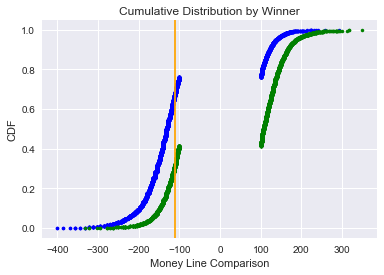

In [60]:
h_win = bball[bball['winner']=='H']
v_win = bball[bball['winner']=='V']

import numpy as np

def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x,y

s_x, s_y = ecdf(h_win['p_ml_home_final'])
b_x, b_y = ecdf(v_win['p_ml_away_final'])


sns.set()
q1 = plt.plot(s_x, s_y, marker='.', color='blue', linestyle='none')
q1 = plt.plot(b_x, b_y, marker='.', color='green', linestyle='none')
plt.axvline(x=-110, color='orange')
plt.title('Cumulative Distribution by Winner')
plt.xlabel('Money Line Comparison')
plt.ylabel('CDF')
plt.show()

The vertical orange line represents an even money line, meaning each team costs the same to bet on--anything to the right of the line is considered an 'underdog' line.

Around 65% of home wins were also betting favorites and around 65% of away wins were underdogs--interesting symmetry. This is the beginning of an approach that searches for 'value bets.' When are the odds skewed one way or the other? And therefore, are there times that the calculated fields identify odds that don't properly value teams?

That may mean picking a team that is unlikely to win, but cheaper to put money on given their performance. A great initial target would be visiting teams with a favorable pyth_ratio and positive odds. Vegas, in these cases, would be overvaluing home field advantage relative to performance.

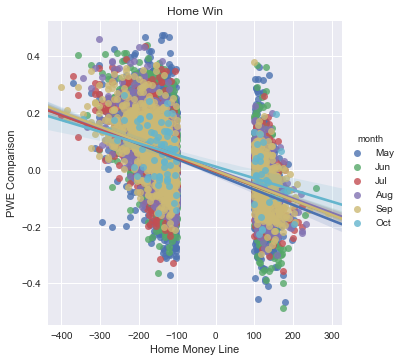

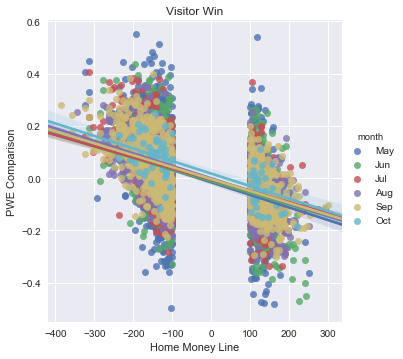

In [61]:
sns.lmplot(data=h_win, x='p_ml_home_final', y='pyth_diff', hue='month')
plt.ylabel('PWE Comparison')
plt.xlabel('Home Money Line')
plt.title('Home Win')

sns.lmplot(data=v_win, x='p_ml_home_final', y='pyth_diff', hue='month')
plt.ylabel('PWE Comparison')
plt.xlabel('Home Money Line')
plt.title('Visitor Win')
plt.show()

The scatter plots above show the PWE comparison and betting lines condense as the season goes on--the more information available, the tighter the spreads get.

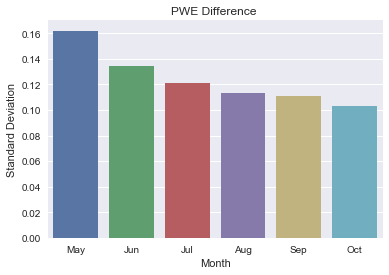

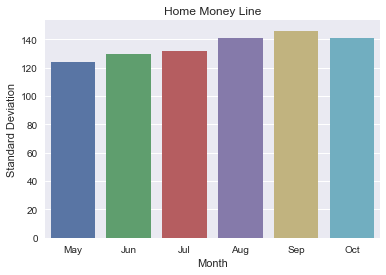

In [62]:
order = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
dist = bball[['month', 'pyth_diff']].groupby('month').std().reindex(order).reset_index()
sns.barplot(x='month', y="pyth_diff", data=dist, order=dist['month'])
plt.xlabel('Month')
plt.ylabel('Standard Deviation')
plt.title('PWE Difference ')
plt.show()

dist = v_win[['month', 'p_ml_home_final']].groupby('month').std().reindex(order).reset_index()
sns.barplot(x='month', y="p_ml_home_final", data=dist, order=dist['month'])
plt.xlabel('Month')
plt.ylabel('Standard Deviation')
plt.title('Home Money Line')
plt.show()

Interestingly, the standard deviation for the PWE difference decreases as the season progresses, but the standard deviation for the betting odds increases as the season goes on. Teams become generally more competitive with each other while Vegas takes bigger positions in the market. This could mean the end of the season will see more payouts, even putting aside the fact that I have more information surrounding these teams.

In [63]:
h_win = h_win.fillna(0)
v_win = v_win.fillna(0)

h_win = h_win[h_win['home_s_pitcher']!=0]
v_win = v_win[v_win['home_s_pitcher']!=0]

Now, let's look at the cumulative distribution for the PWE difference for home and away wins.

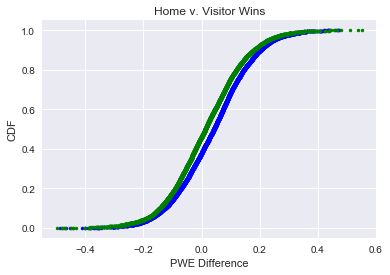

In [64]:
s_x, s_y = ecdf(h_win['pyth_diff'])
b_x, b_y = ecdf(v_win['pyth_diff'])

q1 = plt.plot(s_x, s_y, marker='.', color='blue', linestyle='none')
q1 = plt.plot(b_x, b_y, marker='.', color='green', linestyle='none')
plt.xlabel('PWE Difference')
plt.ylabel('CDF')
plt.title('Home v. Visitor Wins')
plt.show()

In [65]:
test2 = CompareMeans.from_data(h_win['pyth_diff'], v_win['pyth_diff']).ztest_ind(usevar='unequal')
print('PWE Ratio Z-Test:', test2)

PWE Ratio Z-Test: (11.295865433430793, 1.3754244279390649e-29)


The results confirm that there is a difference between the PWE comparison for home and away victories--home winners often have bettwer PWE's. We can leverage this as we begin implementing some regression analysis. Below are the breakdowns for each calculated field for home and away victories.

In [66]:
h_win[['comp_ldr','comp_gbr', 'comp_FIP', 'comp_wOBA', 'comp_BABIP', 'comp_kbr',
       'comp_ldr_5', 'comp_gbr_5', 'comp_FIP_5', 'comp_wOBA_5',
       'comp_BABIP_5', 'comp_kbr_5', 'comp_ldr_10', 'comp_gbr_10',
       'comp_FIP_10', 'comp_wOBA_10', 'comp_BABIP_10', 'comp_kbr_10',
       'pyth_ratio_home', 'pyth_ratio_vis']].describe()

,comp_ldr,comp_gbr,comp_FIP,comp_wOBA,comp_BABIP,comp_kbr,comp_ldr_5,comp_gbr_5,comp_FIP_5,comp_wOBA_5,comp_BABIP_5,comp_kbr_5,comp_ldr_10,comp_gbr_10,comp_FIP_10,comp_wOBA_10,comp_BABIP_10,comp_kbr_10,pyth_ratio_home,pyth_ratio_vis
count,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000,7726.000000
mean,0.049298,0.014098,0.035941,0.008788,0.007301,0.092649,0.052687,0.015821,0.185576,0.008315,0.005023,-0.050954,0.052537,0.015030,0.057342,0.007582,0.006469,0.062686,1.124491,0.956255
std,0.098099,0.135967,1.037381,0.087481,0.079421,1.434136,0.125187,0.156079,2.381361,0.105196,0.099262,3.783200,0.098650,0.146068,1.494347,0.097011,0.089758,2.853184,0.312986,0.263089
min,-0.857981,-0.378434,-12.488032,-0.222591,-0.215557,-15.047831,-0.905256,-0.476089,-44.899049,-0.346358,-0.411559,-21.953947,-0.656899,-0.475117,-13.785329,-0.299494,-0.275652,-25.963492,0.317702,0.336394
25%,-0.002961,-0.042488,-0.599195,-0.025383,-0.025918,-0.655728,-0.022665,-0.066352,-1.210313,-0.049969,-0.050862,-1.891744,-0.006851,-0.054424,-0.930911,-0.041088,-0.040820,-1.173390,0.907234,0.777810
50%,0.054875,0.001180,0.023611,-0.000049,0.000411,0.046788,0.050618,0.003839,0.137813,0.000908,-0.002486,-0.045091,0.050988,0.002524,0.063969,-0.000741,-0.000453,0.053651,1.089060,0.918223
75%,0.105427,0.044124,0.640874,0.026207,0.026630,0.741844,0.127700,0.072583,1.525017,0.050320,0.048841,1.784178,0.109013,0.060245,1.037051,0.040051,0.040653,1.274941,1.285661,1.102251
max,0.494184,1.090041,12.195631,0.604588,0.533493,12.141763,0.691495,1.175452,42.645118,0.662744,0.624331,23.009788,0.640538,1.107491,11.857588,0.626818,0.615762,22.988969,2.972701,3.147603


In [67]:
v_win[['comp_ldr','comp_gbr', 'comp_FIP', 'comp_wOBA', 'comp_BABIP', 'comp_kbr',
       'comp_ldr_5', 'comp_gbr_5', 'comp_FIP_5', 'comp_wOBA_5',
       'comp_BABIP_5', 'comp_kbr_5', 'comp_ldr_10', 'comp_gbr_10',
       'comp_FIP_10', 'comp_wOBA_10', 'comp_BABIP_10', 'comp_kbr_10',
       'pyth_ratio_home', 'pyth_ratio_vis']].describe()

,comp_ldr,comp_gbr,comp_FIP,comp_wOBA,comp_BABIP,comp_kbr,comp_ldr_5,comp_gbr_5,comp_FIP_5,comp_wOBA_5,comp_BABIP_5,comp_kbr_5,comp_ldr_10,comp_gbr_10,comp_FIP_10,comp_wOBA_10,comp_BABIP_10,comp_kbr_10,pyth_ratio_home,pyth_ratio_vis
count,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000,6807.000000
mean,0.056080,0.034311,0.121368,0.022800,0.019245,0.123769,0.058502,0.035258,0.051943,0.025067,0.021108,0.096993,0.059065,0.035227,0.065926,0.022817,0.020113,0.129226,1.069203,1.005558
std,0.106225,0.189751,1.037229,0.116707,0.105367,1.652987,0.130647,0.205104,2.554416,0.130465,0.120705,3.927451,0.107105,0.196958,1.477793,0.124091,0.113418,2.925982,0.301383,0.275393
min,-0.994338,-0.364617,-6.882076,-0.290568,-0.223911,-16.607907,-1.020527,-0.548733,-50.115623,-0.377490,-0.292663,-44.603175,-0.948890,-0.399170,-8.345605,-0.303610,-0.271203,-25.453608,0.383856,0.251211
25%,-0.001119,-0.042193,-0.508188,-0.021764,-0.023504,-0.724718,-0.020036,-0.062744,-1.279186,-0.043580,-0.044352,-1.810062,-0.005403,-0.054386,-0.910581,-0.035345,-0.036260,-1.220671,0.864930,0.820463
50%,0.057283,0.003849,0.099554,0.004287,0.002811,-0.024752,0.053314,0.006444,0.079478,0.008458,0.006200,0.017648,0.054002,0.006301,0.056268,0.005509,0.004882,0.050480,1.026519,0.974166
75%,0.110431,0.049012,0.739531,0.031527,0.029983,0.722395,0.130720,0.078184,1.424189,0.061534,0.060256,1.972607,0.111897,0.066125,0.994869,0.047823,0.047632,1.309309,1.218825,1.156163
max,0.530753,1.068937,8.770598,0.640269,0.560721,20.147822,0.698337,1.128953,53.697261,0.727225,0.672089,24.030075,0.617342,1.112271,9.231605,0.687292,0.642660,23.998462,3.980712,2.605147


### Machine Learning Approach

Taking a step back, there a few ways to approach predictions and a few ways to measure success.

Clearly, sports gambling in general is a tough gig. Nearly everything is normally distributed and, while there are differences between winners, there are many exceptions that make it totally unobvious who has a higher liklihood of success. Again, even the best teams lose forty percent of the time. So I don't expect to get even close to an eighty percent correct prediction rate. But accuracy isn't the most important element here. We're working in a futures market with different prices for each matchup--the prices are what will get this project into the profit margin.

If I can get a sixty percent prediction rate and scale bets based on confidence in that outcome, I'll have a good shot at profitability. I'm separating my training and test data by season--the some seasons will fit the model and the rest will be used as test data.

First, I'm running a logistic regression to predict a winner and the over/under without scaling bets. Next, I'll run a linear regression to predict home and away runs respectively--and by extension, the total number of runs--using those numbers to inform my bet scaling. Then, I'll combine the two approaches, reconcile discrepencies, and scale the bets. I'll play around with the training and test data, the scale, and a quantity for home field advantage.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [23]:
# create dummy variables
for elem in bball['month'].unique():
    bball[str(elem)] = bball['month'] == elem

for elem in bball['game_site'].unique():
    bball[str(elem)] = bball['game_site'] == elem

In [24]:
year_cutoff = 2017

### Logistic Regressions

In [25]:
train = bball[['game_id', 'home_win', 'fav_win', 'ou6', 'ou7', 'ou8', 'p_ml_home_final',
            'pyth_ratio_home', 'dh', 'comp_ldr', 'comp_FIP', 'comp_wOBA', 
            'comp_FIP_5', 'comp_wOBA_5','comp_ldr_10','comp_wOBA_10',
            'Jun', 'Jul', 'Aug', 'Sep', 'Oct']][bball['season'].astype(int) < year_cutoff]

test = bball[['game_id', 'home_win', 'fav_win', 'ou6', 'ou7', 'ou8', 'p_ml_home_final',
            'pyth_ratio_home', 'dh', 'comp_ldr', 'comp_FIP', 'comp_wOBA', 
            'comp_FIP_5', 'comp_wOBA_5','comp_ldr_10','comp_wOBA_10',
            'Jun', 'Jul', 'Aug', 'Sep', 'Oct']][bball['season'].astype(int) >= year_cutoff]

In [26]:
X = train.drop(['game_id', 'home_win', 'fav_win', 'ou6', 'ou7', 'ou8'], axis=1)
Y1 = train['home_win'].values
Y2 = train['ou6'].values
Y3 = train['ou7'].values
Y4 = train['ou8'].values


logreg = LogisticRegression()
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
steps = [('imputation', imp), ('logistic_regression', logreg)]
pipeline = Pipeline(steps)

# Home Win Prediction
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, Y1, test_size=0.8, random_state=42)
pipeline.fit(Xlr, ylr)
test['log_prediction_winner'] = pipeline.predict(test.drop(['game_id', 'home_win', 'fav_win', 'ou6', 'ou7', 'ou8'], axis=1))

# Over 6 Prediction
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, Y2, test_size=0.8, random_state=42)
pipeline.fit(Xlr, ylr)
test['log_prediction_ou6'] = pipeline.predict(test.drop(['game_id', 'home_win', 'fav_win', 'ou6', 'ou7', 'ou8', 'log_prediction_winner'], axis=1))

# Over 7 Prediction
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, Y3, test_size=0.8, random_state=42)
pipeline.fit(Xlr, ylr)
test['log_prediction_ou7'] = pipeline.predict(test.drop(['game_id', 'home_win', 'fav_win', 'ou6', 
                                                         'ou7', 'ou8', 'log_prediction_winner', 'log_prediction_ou6'], axis=1))
# Over 8 Prediction
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, Y4, test_size=0.8, random_state=42)
pipeline.fit(Xlr, ylr)
test['log_prediction_ou8'] = pipeline.predict(test.drop(['game_id', 'home_win', 'fav_win', 'ou6',
                                                         'ou7', 'ou8', 'log_prediction_winner', 'log_prediction_ou6', 'log_prediction_ou7'], axis=1))

test = test[['game_id', 'log_prediction_winner', 'log_prediction_ou6', 'log_prediction_ou7', 'log_prediction_ou8']]

### Linear Regressions

In [27]:
train1 = bball[['home_final', 'vis_final', 'season', 'p_ml_home_final','pyth_ratio_home', 'dh','Jun', 'Jul', 'Aug', 'Sep', 'Oct',
            'home_s_ldr_c', 'home_s_ldr_5', 'home_s_ldr_10', 'home_s_gbr_c','home_bat_ldr_c', 
            'home_bat_ldr_5','home_bat_ldr_10', 'home_bat_gbr_c', 'home_bat_gbr_5','home_bat_gbr_10',
            'home_bat_fbr_c', 'home_bat_fbr_5','home_bat_fbr_10', 'home_bat_hr_fb_c', 'home_bat_hrfb_5',
            'home_bat_hrfb_10', 'home_bat_xFIP_c', 'home_bat_xFIP_5','home_bat_xFIP_10', 'home_bat_wOBA_c',
            'home_bat_wOBA_5','home_bat_wOBA_10', 'home_bat_BABIP_c', 'home_bat_BABIP_5','home_bat_BABIP_10',
            'home_bat_kb_r_c', 'home_bat_kb_r_5','home_bat_kb_r_10', 'm_ldr_off', 'm_ldr_off','m_gbr_off',
            'm_xFIP_off', 'm_wOBA_off', 'm_BABIP_off','m_kbr_off', 'm_ldr_off_5', 'm_gbr_off_5','m_xFIP_off_5',
            'm_wOBA_off_5', 'm_BABIP_off_5','m_kbr_off_5']][bball['season'].astype(int) < year_cutoff]
test1 = bball[['game_id', 'home_win', 'home_final', 'vis_final', 'season', 'p_ml_home_final','pyth_ratio_home', 'dh','Jun', 'Jul', 
               'Aug', 'Sep', 'Oct',
            'home_s_ldr_c', 'home_s_ldr_5', 'home_s_ldr_10', 'home_s_gbr_c','home_bat_ldr_c', 
            'home_bat_ldr_5','home_bat_ldr_10', 'home_bat_gbr_c', 'home_bat_gbr_5','home_bat_gbr_10',
            'home_bat_fbr_c', 'home_bat_fbr_5','home_bat_fbr_10', 'home_bat_hr_fb_c', 'home_bat_hrfb_5',
            'home_bat_hrfb_10', 'home_bat_xFIP_c', 'home_bat_xFIP_5','home_bat_xFIP_10', 'home_bat_wOBA_c',
            'home_bat_wOBA_5','home_bat_wOBA_10', 'home_bat_BABIP_c', 'home_bat_BABIP_5','home_bat_BABIP_10',
            'home_bat_kb_r_c', 'home_bat_kb_r_5','home_bat_kb_r_10', 'm_ldr_off', 'm_ldr_off','m_gbr_off',
            'm_xFIP_off', 'm_wOBA_off', 'm_BABIP_off','m_kbr_off', 'm_ldr_off_5', 'm_gbr_off_5','m_xFIP_off_5',
            'm_wOBA_off_5', 'm_BABIP_off_5','m_kbr_off_5']][bball['season'].astype(int) >= year_cutoff]

train2 = bball[['home_final', 'vis_final', 'season', 'p_ml_home_final','pyth_ratio_vis', 'dh','Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                'vis_s_ldr_c', 'vis_s_ldr_5', 'vis_s_ldr_10', 'vis_s_gbr_c','vis_bat_ldr_c', 
                'vis_bat_ldr_5','vis_bat_ldr_10', 'vis_bat_gbr_c', 'vis_bat_gbr_5','vis_bat_gbr_10',
                'vis_bat_fbr_c', 'vis_bat_fbr_5','vis_bat_fbr_10', 'vis_bat_hr_fb_c', 'vis_bat_hrfb_5',
                'vis_bat_hrfb_10', 'vis_bat_xFIP_c', 'vis_bat_xFIP_5','vis_bat_xFIP_10', 'vis_bat_wOBA_c',
                'vis_bat_wOBA_5','vis_bat_wOBA_10', 'vis_bat_BABIP_c', 'vis_bat_BABIP_5','vis_bat_BABIP_10',
                'vis_bat_kb_r_c', 'vis_bat_kb_r_5','vis_bat_kb_r_10', 'm_ldr_def', 'm_ldr_def','m_gbr_def',
                'm_xFIP_def', 'm_wOBA_def', 'm_BABIP_def','m_kbr_def', 'm_ldr_def_5', 'm_gbr_def_5','m_xFIP_def_5',
                'm_wOBA_def_5', 'm_BABIP_def_5','m_kbr_def_5']][bball['season'].astype(int) < year_cutoff]
test2 = bball[['game_id', 'home_final', 'vis_final', 'season', 'p_ml_home_final','pyth_ratio_vis', 'dh','Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                'vis_s_ldr_c', 'vis_s_ldr_5', 'vis_s_ldr_10', 'vis_s_gbr_c','vis_bat_ldr_c', 
                'vis_bat_ldr_5','vis_bat_ldr_10', 'vis_bat_gbr_c', 'vis_bat_gbr_5','vis_bat_gbr_10',
                'vis_bat_fbr_c', 'vis_bat_fbr_5','vis_bat_fbr_10', 'vis_bat_hr_fb_c', 'vis_bat_hrfb_5',
                'vis_bat_hrfb_10', 'vis_bat_xFIP_c', 'vis_bat_xFIP_5','vis_bat_xFIP_10', 'vis_bat_wOBA_c',
                'vis_bat_wOBA_5','vis_bat_wOBA_10', 'vis_bat_BABIP_c', 'vis_bat_BABIP_5','vis_bat_BABIP_10',
                'vis_bat_kb_r_c', 'vis_bat_kb_r_5','vis_bat_kb_r_10', 'm_ldr_def', 'm_ldr_def','m_gbr_def',
                'm_xFIP_def', 'm_wOBA_def', 'm_BABIP_def','m_kbr_def', 'm_ldr_def_5', 'm_gbr_def_5','m_xFIP_def_5',
                'm_wOBA_def_5', 'm_BABIP_def_5','m_kbr_def_5']][bball['season'].astype(int) >= year_cutoff]

In [28]:
X1 = train1.drop(['home_final', 'vis_final', 'season'], axis=1)
X2 = train2.drop(['home_final', 'vis_final', 'season'], axis=1)

Y1 = train1['home_final'].values
Y2 = train2['vis_final'].values

score = LinearRegression()
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
steps = [('imputation', imp), ('linear_regression', score)]

pipeline1 = Pipeline(steps)
pipeline2 = Pipeline(steps)

# Split the data into a training and test set.
Xlr1, Xtestlr1, ylr1, ytestlr1 = train_test_split(X1, Y1, test_size=.8, random_state=42)
Xlr2, Xtestlr2, ylr2, ytestlr2 = train_test_split(X2, Y2, test_size=.8, random_state=42)

# Fit the model on the training data.
pipeline1.fit(Xlr1, ylr1)
pipeline2.fit(Xlr2, ylr2)

Pipeline(memory=None,
     steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('linear_regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [29]:
test1['lin_home_predict'] = pipeline1.predict(test1.drop(['home_final', 'vis_final', 'game_id', 'season', 'home_win'], axis=1))
test2['lin_vis_predict'] = pipeline2.predict(test2.drop(['home_final', 'vis_final', 'game_id', 'season', 'home_win'], axis=1))

test1 = test1[['game_id', 'home_final', 'vis_final', 'lin_home_predict', 'home_win']]
test2 = test2[['game_id', 'lin_vis_predict']]

test_comb = test1.merge(test2, how='inner', on='game_id')

test_comb['lin_predicted_run_diff'] = test_comb['lin_home_predict'] - test_comb['lin_vis_predict']
test_comb['lin_predicted_run_total'] = test_comb['lin_home_predict'] + test_comb['lin_vis_predict']

test = test.merge(test_comb, how='inner', on='game_id')
test  = test[['game_id', 'home_win', 'home_final', 'vis_final', 'log_prediction_winner', 'log_prediction_ou6',
              'log_prediction_ou7', 'log_prediction_ou8', 'lin_home_predict', 'lin_vis_predict','lin_predicted_run_diff',
              'lin_predicted_run_total']]

In [30]:
games = bball[['game_id', 'odds_matchup', 'date', 'weekday', 'season', 'month','home_team', 
               'visiting_team_x', 'p_ml_home_final', 'p_ml_away_final', 'p_over_6-5_final', 
               'p_under_6-5_final', 'p_over_7-5_final','p_under_7-5_final', 'p_over_8-5_final',
               'p_under_8-5_final']][bball['season'].astype(int) >= year_cutoff]

games = games.merge(test, how='inner', on='game_id').fillna(0)

In [31]:
# Can scale based on risk appetite
games['wager'] = 100

## TEST TEST 

In [32]:
projected_home_win = []
for row in games['lin_predicted_run_diff']:
    if row <= 0:
        projected_home_win.append(0)
    else:
        projected_home_win.append(1) 
games['lin_projected_home_win'] = projected_home_win

In [33]:
o6 = []
o7 = []
o8 = []
for row in games['lin_predicted_run_total']:
    if row < 6:
        o6.append(0)
        o7.append(0)
        o8.append(0)
    elif row < 7:
        o6.append(1)
        o7.append(0)
        o8.append(0)
    elif row < 8:
        o6.append(1)
        o7.append(1)
        o8.append(0)
    else:
        o6.append(1)
        o7.append(1)
        o8.append(1)
        
games['lin_projected_o6'] = o6
games['lin_projected_o7'] = o7
games['lin_projected_o8'] = o8

In [34]:
games['final_runs'] = games['home_final'] + games['vis_final']

o6 = []
o7 = []
o8 = []
for row in games['final_runs']:
    if row < 6:
        o6.append(0)
        o7.append(0)
        o8.append(0)
    elif row < 7:
        o6.append(1)
        o7.append(0)
        o8.append(0)
    elif row < 8:
        o6.append(1)
        o7.append(1)
        o8.append(0)
    else:
        o6.append(1)
        o7.append(1)
        o8.append(1)
games['final_o6'] = o6
games['final_o7'] = o7
games['final_o8'] = o8

In [35]:
def correct_prediction(prediction, outcome):
    cp = []
    for index, row in games.iterrows():
        if row[prediction]==row[outcome]:
            cp.append(1)
        else:
            cp.append(0)
    return cp

games['r_log_win'] = correct_prediction('log_prediction_winner', 'home_win')
games['r_log_o6'] = correct_prediction('log_prediction_ou6', 'final_o6')
games['r_log_o7'] = correct_prediction('log_prediction_ou7', 'final_o7')
games['r_log_o8'] = correct_prediction('log_prediction_ou8', 'final_o8')

games['r_lin_win'] = correct_prediction('lin_projected_home_win', 'home_win')
games['r_lin_o6'] = correct_prediction('lin_projected_o6', 'final_o6')
games['r_lin_o7'] = correct_prediction('lin_projected_o7', 'final_o7')
games['r_lin_o8'] = correct_prediction('lin_projected_o8', 'final_o8')

In [36]:
def relevant_odds(prediction_col, home_odds, vis_odds):
    relevant_odds = []
    for index, row in games.iterrows():
        if row[prediction_col]==1:
            odds = row[home_odds]
        else:
            odds = row[vis_odds]
        relevant_odds.append(odds)
    return relevant_odds

games['r_log_win_odds'] = relevant_odds('log_prediction_winner', 'p_ml_home_final', 'p_ml_away_final')
games['r_log_win_o6'] = relevant_odds('log_prediction_ou6', 'p_over_6-5_final', 'p_under_6-5_final')
games['r_log_win_o7'] = relevant_odds('log_prediction_ou7', 'p_over_7-5_final', 'p_under_7-5_final')
games['r_log_win_o8'] = relevant_odds('log_prediction_ou8', 'p_over_8-5_final', 'p_under_8-5_final')

games['r_lin_win_odds'] = relevant_odds('lin_projected_home_win', 'p_ml_home_final', 'p_ml_away_final')
games['r_lin_win_o6'] = relevant_odds('lin_projected_o6', 'p_over_6-5_final', 'p_under_6-5_final')
games['r_lin_win_o7'] = relevant_odds('lin_projected_o7', 'p_over_7-5_final', 'p_under_7-5_final')
games['r_lin_win_o8'] = relevant_odds('lin_projected_o8', 'p_over_8-5_final', 'p_under_8-5_final')

In [37]:
wager_adj = []
for index, row in games.iterrows():
    if abs(row['lin_predicted_run_diff']) < 1:
        bet = row['wager']
    elif abs(row['lin_predicted_run_diff']) < 1.5:
        bet = row['wager'] * 2
    elif abs(row['lin_predicted_run_diff']) < 2:
        bet = row['wager'] * 3
    elif abs(row['lin_predicted_run_diff']) < 2.5:
        bet = row['wager'] * 4
    else:
        bet = row['wager']*5
    wager_adj.append(bet)
games['ml_wager_adj'] = wager_adj

In [38]:
wager_adj6 = []
wager_adj7 = []
wager_adj8 = []

for index, row in games.iterrows():
    
    diff6 = abs(row['lin_predicted_run_total'] - 6)
    diff7 = abs(row['lin_predicted_run_total'] - 7)
    diff8 = abs(row['lin_predicted_run_total'] - 8)
    
    if diff6 < 1:
        wager_adj6.append(row['wager'])
    elif diff6 < 2:
        wager_adj6.append(row['wager'] * 2)
    elif diff6 < 3:
        wager_adj6.append(row['wager'] * 3)
    elif diff6 < 4:
        wager_adj6.append(row['wager'] * 4)
    else:
        wager_adj6.append(row['wager'] * 5)
       
    if diff7 < 1:
        wager_adj7.append(row['wager'])
    elif diff7 < 2:
        wager_adj7.append(row['wager'] * 2)
    elif diff7 < 3:
        wager_adj7.append(row['wager'] * 3)
    elif diff7 < 4:
        wager_adj7.append(row['wager'] * 4)
    else:
        wager_adj7.append(row['wager'] * 5)
        
    if diff8 < 1:
        wager_adj8.append(row['wager'])
    elif diff8 < 2:
        wager_adj8.append(row['wager'] * 2)
    elif diff8 < 3:
        wager_adj8.append(row['wager'] * 3)
    elif diff8 < 4:
        wager_adj8.append(row['wager'] * 4)
    else:
        wager_adj8.append(row['wager'] * 5)
    
games['o6_wager_adj'] = wager_adj6
games['o7_wager_adj'] = wager_adj7
games['o8_wager_adj'] = wager_adj8

In [39]:
def potential_payout(odds_column, bet):
    payout_cash = []
    for index, row in games.iterrows():
        if row[odds_column] < 0:
            pay = round(((100/abs(row[odds_column]))*row[bet]), 2)
        else: 
            pay = round(((row[odds_column]/100)*row[bet]), 2)
        payout_cash.append(pay)
    return payout_cash


games['r_log_win_potential_payout_adj'] = potential_payout('r_log_win_odds', 'ml_wager_adj')
games['r_log_o6_potential_payout_adj'] = potential_payout('r_log_win_o6', 'o6_wager_adj')
games['r_log_o7_potential_payout_adj'] = potential_payout('r_log_win_o7', 'o7_wager_adj')
games['r_log_o8_potential_payout_adj'] = potential_payout('r_log_win_o8', 'o8_wager_adj')

games['r_log_win_potential_payout'] = potential_payout('r_log_win_odds', 'wager')
games['r_log_o6_potential_payout'] = potential_payout('r_log_win_o6', 'wager')
games['r_log_o7_potential_payout'] = potential_payout('r_log_win_o7', 'wager')
games['r_log_o8_potential_payout'] = potential_payout('r_log_win_o8', 'wager')

games['r_lin_win_potential_payout_adj'] = potential_payout('r_lin_win_odds', 'ml_wager_adj')
games['r_lin_o6_potential_payout_adj'] = potential_payout('r_lin_win_o6', 'o6_wager_adj')
games['r_lin_o7_potential_payout_adj'] = potential_payout('r_lin_win_o7', 'o7_wager_adj')
games['r_lin_o8_potential_payout_adj'] = potential_payout('r_lin_win_o8', 'o8_wager_adj')

games['r_lin_win_potential_payout'] = potential_payout('r_lin_win_odds', 'wager')
games['r_lin_o6_potential_payout'] = potential_payout('r_lin_win_o6', 'wager')
games['r_lin_o7_potential_payout'] = potential_payout('r_lin_win_o7', 'wager')
games['r_lin_o8_potential_payout'] = potential_payout('r_lin_win_o8', 'wager')

In [40]:
def actual_payout(prediction_outcome, potential_payout, wager):
    actual_payout = []
    for index, row in games.iterrows():
        if row[prediction_outcome]==1:
            actual_payout.append(row[potential_payout])
        else:
            actual_payout.append(row[wager] * -1)
    return actual_payout


games['r_log_win_actual_payout_adj'] = actual_payout('r_log_win', 'r_log_win_potential_payout_adj', 'ml_wager_adj')
games['r_log_o6_actual_payout_adj'] = actual_payout('r_log_o6', 'r_log_o6_potential_payout_adj', 'o6_wager_adj')
games['r_log_o7_actual_payout_adj'] = actual_payout('r_log_o7', 'r_log_o7_potential_payout_adj', 'o7_wager_adj')
games['r_log_o8_actual_payout_adj'] = actual_payout('r_log_o8', 'r_log_o8_potential_payout_adj', 'o8_wager_adj')

games['r_lin_win_actual_payout_adj'] = actual_payout('r_lin_win', 'r_lin_win_potential_payout_adj', 'ml_wager_adj')
games['r_lin_o6_actual_payout_adj'] = actual_payout('r_lin_o6', 'r_lin_o6_potential_payout_adj', 'o6_wager_adj')
games['r_lin_o7_actual_payout_adj'] = actual_payout('r_lin_o7', 'r_lin_o7_potential_payout_adj', 'o7_wager_adj')
games['r_lin_o8_actual_payout_adj'] = actual_payout('r_lin_o8', 'r_lin_o8_potential_payout_adj', 'o8_wager_adj')



games['r_log_win_actual_payout'] = actual_payout('r_log_win', 'r_log_win_potential_payout', 'wager')
games['r_log_o6_actual_payout'] = actual_payout('r_log_o6', 'r_log_o6_potential_payout', 'wager')
games['r_log_o7_actual_payout'] = actual_payout('r_log_o7', 'r_log_o7_potential_payout', 'wager')
games['r_log_o8_actual_payout'] = actual_payout('r_log_o8', 'r_log_o8_potential_payout', 'wager')

games['r_lin_win_actual_payout'] = actual_payout('r_lin_win', 'r_lin_win_potential_payout', 'wager')
games['r_lin_o6_actual_payout'] = actual_payout('r_lin_o6', 'r_lin_o6_potential_payout', 'wager')
games['r_lin_o7_actual_payout'] = actual_payout('r_lin_o7', 'r_lin_o7_potential_payout', 'wager')
games['r_lin_o8_actual_payout'] = actual_payout('r_lin_o8', 'r_lin_o8_potential_payout', 'wager')

In [41]:
games[['r_log_win', 'r_log_o6', 'r_log_o7', 'r_log_o8',
       'r_lin_win', 'r_lin_o6', 'r_lin_o7', 'r_lin_o8']].describe()

,r_log_win,r_log_o6,r_log_o7,r_log_o8,r_lin_win,r_lin_o6,r_lin_o7,r_lin_o8
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,0.581106,0.790553,0.633313,0.443132,0.540709,0.783095,0.701678,0.590429
std,0.493531,0.407040,0.482050,0.496910,0.498495,0.412265,0.457664,0.491908
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
rig = games[['date', 'home_win', 'p_ml_away_final', 'r_log_win_actual_payout', 'r_log_win_actual_payout_adj', 'r_lin_win_actual_payout', 'r_lin_win_actual_payout_adj']]
rig

,date,home_win,p_ml_away_final,r_log_win_actual_payout,r_log_win_actual_payout_adj,r_lin_win_actual_payout,r_lin_win_actual_payout_adj
0,2017-05-01,0,138.0,-100.00,-100.00,-100.00,-100.00
1,2017-05-01,1,-133.0,-100.00,-100.00,124.00,124.00
2,2017-05-01,0,124.0,-100.00,-100.00,124.00,124.00
3,2017-05-01,1,-106.0,98.04,294.12,98.04,294.12
4,2017-05-01,0,166.0,-100.00,-100.00,-100.00,-100.00
5,2017-05-01,0,100.0,-100.00,-100.00,100.00,100.00
6,2017-05-02,1,150.0,60.98,60.98,-100.00,-100.00
7,2017-05-02,1,203.0,45.05,45.05,45.05,45.05
8,2017-05-02,0,135.0,-100.00,-100.00,-100.00,-100.00
9,2017-05-02,0,165.0,-100.00,-400.00,-100.00,-400.00


In [43]:
rolling_dollars = rig.groupby('date').sum().reset_index()
rolling_dollars

,date,home_win,p_ml_away_final,r_log_win_actual_payout,r_log_win_actual_payout_adj,r_lin_win_actual_payout,r_lin_win_actual_payout_adj
0,2017-05-01,2,289.0,-401.96,-205.88,246.04,442.12
1,2017-05-02,8,3055.0,-1790.05,-1923.06,1479.99,1025.03
2,2017-05-03,9,609.0,540.63,1015.43,-128.22,-331.70
3,2017-05-04,5,1481.0,-254.08,-1163.26,52.02,123.98
4,2017-05-05,4,492.0,74.05,321.38,158.24,505.74
5,2017-05-06,8,707.0,-389.67,-1108.37,477.29,630.59
6,2017-05-07,6,-148.0,157.15,678.64,418.03,748.67
7,2017-05-08,3,242.0,304.41,537.41,-25.03,207.97
8,2017-05-09,6,-192.0,-259.84,155.73,-71.71,423.90
9,2017-05-10,8,729.0,62.96,-7.22,140.75,398.81


In [44]:
rolling_dollars['r_log_win_rolling'] = rolling_dollars['r_log_win_actual_payout'].cumsum()
rolling_dollars['r_log_win_rolling_adj'] = rolling_dollars['r_log_win_actual_payout_adj'].cumsum()
rolling_dollars['r_lin_win_rolling'] = rolling_dollars['r_lin_win_actual_payout'].cumsum()
rolling_dollars['r_lin_win_rolling_adj'] = rolling_dollars['r_lin_win_actual_payout_adj'].cumsum()

In [45]:
rolling_dollars

,date,home_win,p_ml_away_final,r_log_win_actual_payout,r_log_win_actual_payout_adj,r_lin_win_actual_payout,r_lin_win_actual_payout_adj,r_log_win_rolling,r_log_win_rolling_adj,r_lin_win_rolling,r_lin_win_rolling_adj
0,2017-05-01,2,289.0,-401.96,-205.88,246.04,442.12,-401.96,-205.88,246.04,442.12
1,2017-05-02,8,3055.0,-1790.05,-1923.06,1479.99,1025.03,-2192.01,-2128.94,1726.03,1467.15
2,2017-05-03,9,609.0,540.63,1015.43,-128.22,-331.70,-1651.38,-1113.51,1597.81,1135.45
3,2017-05-04,5,1481.0,-254.08,-1163.26,52.02,123.98,-1905.46,-2276.77,1649.83,1259.43
4,2017-05-05,4,492.0,74.05,321.38,158.24,505.74,-1831.41,-1955.39,1808.07,1765.17
5,2017-05-06,8,707.0,-389.67,-1108.37,477.29,630.59,-2221.08,-3063.76,2285.36,2395.76
6,2017-05-07,6,-148.0,157.15,678.64,418.03,748.67,-2063.93,-2385.12,2703.39,3144.43
7,2017-05-08,3,242.0,304.41,537.41,-25.03,207.97,-1759.52,-1847.71,2678.36,3352.40
8,2017-05-09,6,-192.0,-259.84,155.73,-71.71,423.90,-2019.36,-1691.98,2606.65,3776.30
9,2017-05-10,8,729.0,62.96,-7.22,140.75,398.81,-1956.40,-1699.20,2747.40,4175.11


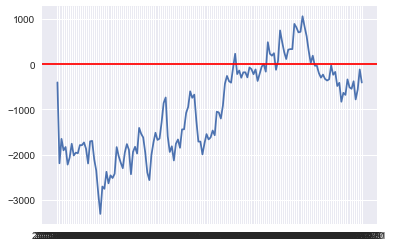

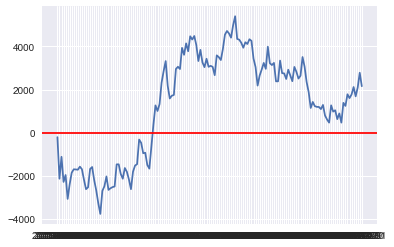

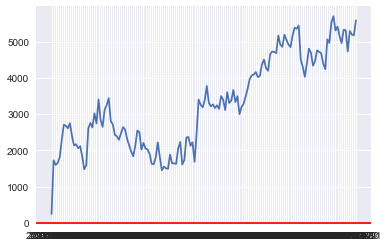

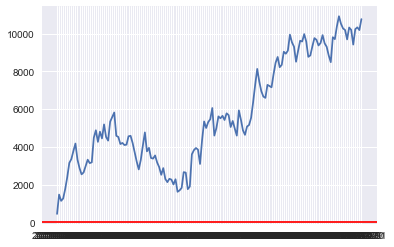

In [46]:
plt.plot(rolling_dollars['date'], rolling_dollars['r_log_win_rolling'])
plt.axhline(y=0, color='red')
plt.show()

plt.plot(rolling_dollars['date'], rolling_dollars['r_log_win_rolling_adj'])
plt.axhline(y=0, color='red')
plt.show()

plt.plot(rolling_dollars['date'], rolling_dollars['r_lin_win_rolling'])
plt.axhline(y=0, color='red')
plt.show()

plt.plot(rolling_dollars['date'], rolling_dollars['r_lin_win_rolling_adj'])
plt.axhline(y=0, color='red')
plt.show()